In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# setup plotting theme
from tufte_mpl import setup, breathe, data_lim
setup()

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.linalg
import scipy.optimize
import sympy as sp
from IPython.display import display, Math
%matplotlib inline

In [4]:
from neuron_populations import *

# Fixed vs. recurrent inhibition

## Excitatory population with self-coupling

$$\tau_k \dot h_k(t) = -h_k(t) + R_k \sum_n W_{kn} A_n(t) + R_k I_{ext,k}(t)$$

where

$$A_n(t) = \int_0^\infty \alpha_n(s) F_n(h_n(t-s)) \; \text{d}s$$

For each population $n$ :
- $\alpha(s)$ is the filtering kernel
- $F(h)$ is the gain function
- $A(t) = F(h(t))$ is the activity in the high noise (slow evolution) approximation
- $R$ the resistivity
- $W_{kn}$ the weight of currents from $n$ into $k$
- $I_{ext}(t)$ the external current
- $h(t)$ inner voltage of the population

### Varying constant $I_{ext}$

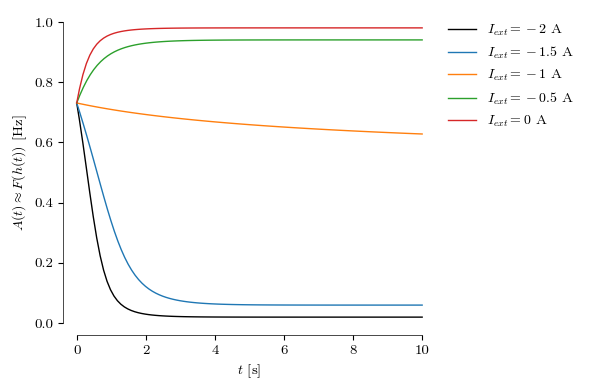

In [16]:
plt.close()
fig, ax = plt.subplots(dpi=100)

for I_ext in (-2, -1.5, -1, -0.5, 0):
	pop = Populations(W=np.array([[2]]), tau=0.60, R=1, gain_fn=sigmoid, I_ext=Flat(I_ext))
	res = pop.simulate_h(np.array([0.5]), (0, 10), dt_max=0.1)
	ax.plot(res.t, pop.gain_fn(res.y[0]), label=f'$I_{{ext}} = {I_ext}$ A')

ax.set_xlabel('$t$ [s]')
ax.set_ylabel('$A(t) \\approx F(h(t))$ [Hz]')
ax.set_ylim((0, 1))
data_lim(ax, which='x')
breathe(ax)
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

# fig.set_size_inches((4, 2))
# fig.savefig('../report/figures/sec111.pdf')

The activity levels out.

- $I_{ext} < -1 \; A$ : activity level decays to 0
- $I_{ext} = -1 \; A$ : threshold, activity level stays constant
- $I_{ext} > -1 \; A$ : activity level grows to 1

### Current spikes in steady state

/run/media/niels/niels_data/Documents/2018 EPFL/PH MA 2/BIO-465 Biological modeling of neural networks/project/BIO465-cortical-surround-suppression/src/neuron_populations/_currents.py:75: RuntimeWarning: overflow encountered in exp
  np.exp(-1/(1-x**2)),
/run/media/niels/niels_data/Documents/2018 EPFL/PH MA 2/BIO-465 Biological modeling of neural networks/project/BIO465-cortical-surround-suppression/src/neuron_populations/_currents.py:75: RuntimeWarning: overflow encountered in exp
  np.exp(-1/(1-x**2)),
/run/media/niels/niels_data/Documents/2018 EPFL/PH MA 2/BIO-465 Biological modeling of neural networks/project/BIO465-cortical-surround-suppression/src/neuron_populations/_currents.py:75: RuntimeWarning: overflow encountered in exp
  np.exp(-1/(1-x**2)),
/run/media/niels/niels_data/Documents/2018 EPFL/PH MA 2/BIO-465 Biological modeling of neural networks/project/BIO465-cortical-surround-suppression/src/neuron_populations/_currents.py:75: RuntimeWarning: overflow encountered in exp
  n

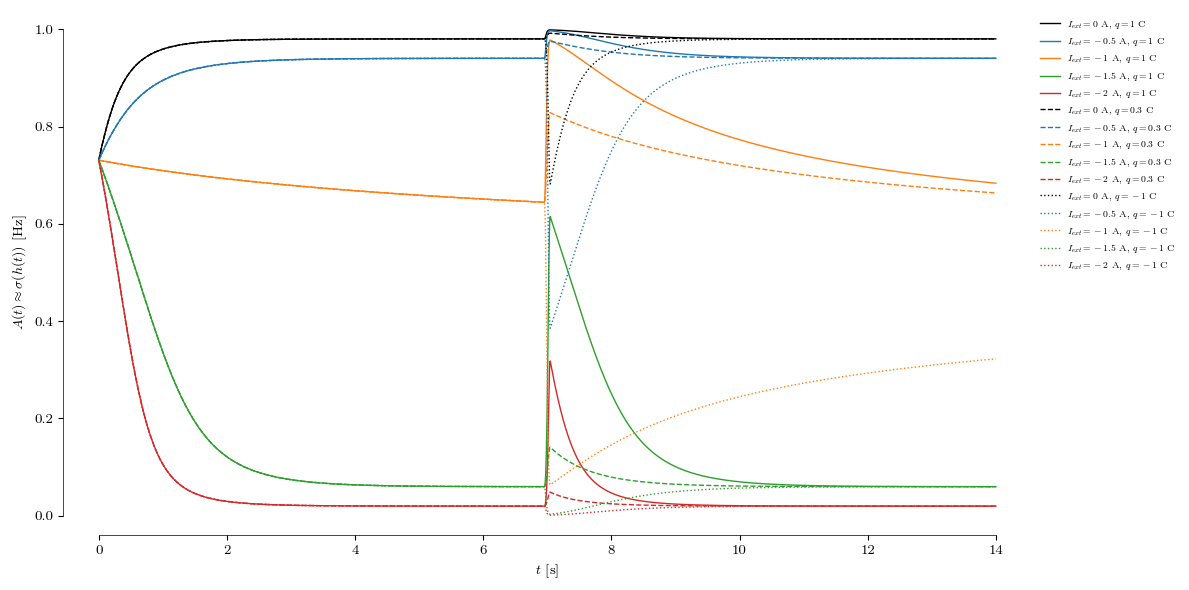

In [24]:
plt.close()
fig, ax = plt.subplots(figsize=(12, 6), dpi=100)
delta = Delta(7)

for idx, spike_charge in enumerate((1, 0.3, -1)):
	ax.set_prop_cycle(None)  # reset color cycle

	for I_ext in reversed((-2, -1.5, -1, -0.5, 0)):
		pop = Populations(W=np.array([[2]]), tau=0.60, R=1, gain_fn=sigmoid, I_ext=Flat(I_ext) + spike_charge*delta)
		res = pop.simulate_h(np.array([0.5]), (0, 14), dt_max=delta.eps/20)
		ax.plot(
			res.t, pop.gain_fn(res.y[0]),
			label=f'$I_{{ext}} = {I_ext}$ A, $q = {spike_charge}$ C',
			linestyle={0: 'solid', 1: 'dashed', 2: 'dotted'}.get(idx)
		)

ax.set_xlabel('$t$ [s]')
ax.set_ylabel('$A(t) \\approx \\sigma(h(t))$ [Hz]')
ax.set_ylim((0, 1))
data_lim(ax, which='x')
breathe(ax)
ax.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize='x-small')
plt.show()


fig.set_size_inches((4, 3))
fig.savefig('../report/figures/pop_single_nonlin.pdf')

Current spike affects (higher amplitude, more time to recovery) unsaturated neurons ($|A| < 1$) more than saturated ones ($|A| \approx 1$).

It is not symmetric : if $A > 1/2$, then for $q < 0$ the perturbation is greather than for $q > 0$ (and vice-versa)

Larger spikes correspond to a higher amplitude response.

### Effect of coupling strength

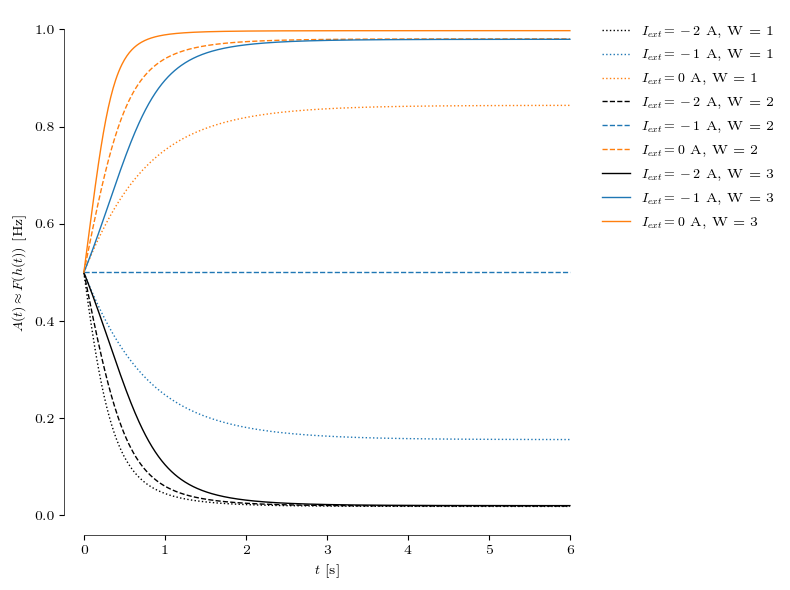

In [7]:
plt.close()
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)

for W in (1, 2, 3):
	ax.set_prop_cycle(None)  # reset color cycle

	for I_ext in (-2, -1, -0):
		pop = Populations(W=np.array([[W]]), tau=0.60, R=1, gain_fn=sigmoid, I_ext=Flat(I_ext))
		res = pop.simulate_h(np.array([0]), (0, 6), dt_max=0.01)
		ax.plot(res.t, pop.gain_fn(res.y[0]), label=f'$I_{{ext}} = {I_ext}$ A, W = {W}', linestyle={1: 'dotted', 2: 'dashed', 3: 'solid'}.get(W))

ax.set_xlabel('$t$ [s]')
ax.set_ylabel('$A(t) \\approx F(h(t))$ [Hz]')
ax.set_ylim((0, 1))
data_lim(ax, which='x')
breathe(ax)
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

- Changing coupling can change the equilibrium ($I_{ext} = 0 \; A$), but also the rate of convergence to the equilibrium ($I_{ext} = - 2 \; A$)
- Less coupling leads to less activity at all times

### Mathematical study of fixed points

#### 1d phase portrait

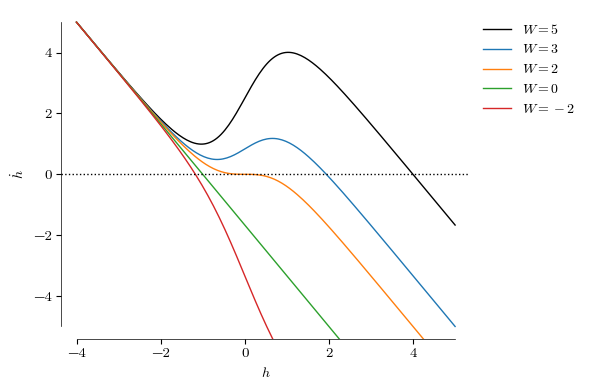

In [6]:
fig, ax = plt.subplots(dpi=100)
hs = np.linspace(-4, 5, 200)

for W in reversed((-2, 0, 2, 3, 5)):
	pop = Populations(W=np.array([[W]]), tau=0.6, R=1, gain_fn=sigmoid, I_ext=Flat(-1))
	ax.plot(hs, [pop.dh(0, np.array([h])) for h in hs], label=f'$W = {W}$')

ax.set_xlabel('$h$')
ax.set_ylabel('$\dot h$')
ax.axhline(0, linestyle='dotted', linewidth=1)
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')

ax.set_ylim((-5, 5))
data_lim(ax, 'x')
breathe(ax)

plt.show()

fig.set_size_inches((4, 2))
fig.savefig('../report/figures/pop_single_nonlin_phase.pdf')

#### Demo of two stable points

In [7]:
R = 1
I = -2
W = 5
F = lambda h: 0.5*(1 + np.tanh(h))
print(scipy.optimize.fsolve(lambda h: -h + R*W*F(h) + R*I, [-3, -2]))
print(scipy.optimize.fsolve(lambda h: -h + R*W*F(h) + R*I, [-0.5, 0]))
print(scipy.optimize.fsolve(lambda h: -h + R*W*F(h) + R*I, [2, 3]))

[-1.88799444 -1.88799444]
[-0.35747913 -0.35747913]
[2.98732016 2.98732016]


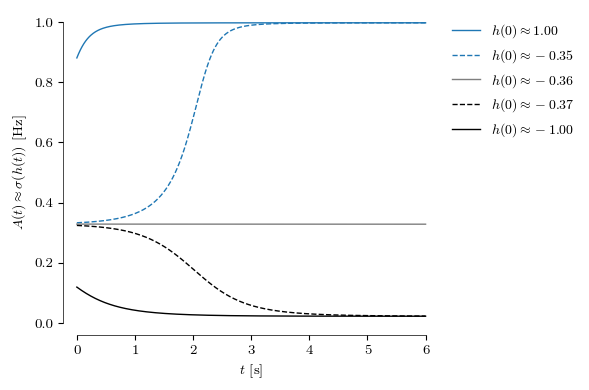

In [23]:
plt.close()
fig, ax = plt.subplots(dpi=100)

pop = Populations(W=np.array([[5]]), tau=0.60, R=1, gain_fn=sigmoid, I_ext=Flat(-2))

for h0, (linecolor, linestyle) in zip(
	reversed((-1, -0.35747913 - 0.01, -0.35747913, -0.35747913 + 0.01, 1)),
	reversed((('k', '-'), ('k', '--'), ('tab:grey', '-'), ('tab:blue', '--'), ('tab:blue', '-')))
):
	res = pop.simulate_h(np.array([h0]), (0, 6), dt_max=0.01)
	ax.plot(
		res.t, pop.gain_fn(res.y[0]),
		linestyle=linestyle, color=linecolor,
		label=f'$h(0) \\approx {h0:.2f}$',
	)

ax.set_xlabel('$t$ [s]')
ax.set_ylabel('$A(t) \\approx \\sigma(h(t))$ [Hz]')
ax.set_ylim((0, 1))
data_lim(ax, which='x')
breathe(ax)
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

fig.set_size_inches((4, 2))
fig.savefig('../report/figures/pop_single_threesol.pdf')

#### Study of the critical parameters

Large weights -> possibility of three fixed points

We find the weights for which the other solutions appear.

For this, there need to exist two local extrema in $\dot h(h)$

In [274]:
h, W, R, I = sp.symbols('h w R I', real=True)
F = (1 + sp.tanh(h)) / 2
rhs = -h + R*W*F + R*I
for sol_h, sol_W, sol_I in sp.solve(
	(
		rhs,
		sp.diff(rhs, h),
		sp.diff(sp.diff(rhs, h), h)
	),
	(h, W, I),
	real=True
):
	display(Math(f'h_{{crit}} = {sp.latex(sol_h)}'))
	display(Math(f'W_{{crit}} = {sp.latex(sol_W)}'))
	display(Math(f'I_{{crit}} = {sp.latex(sol_I)}'))
	print(sol_W.evalf(subs={I: -2, R: 1}))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

2.00000000000000


#### As function (h, I)

In [257]:
h, W, R, I = sp.symbols('h w R I', real=True)
F = (1 + sp.tanh(h)) / 2
dF = sp.diff(F)
for sol_h, sol_I in sp.solve(
	(
		-h + R*W*F + R*I,
		# -1 + R*W*dF
		sp.diff(-h + R*W*F + R*I, h)
	),
	(h, I),
	real=True
):
	display(Math(f'h_{{crit}} = {sp.latex(sol_h)}'))
	display(Math(f'I_{{crit}} = {sp.latex(sol_I)}'))
	print(sol_I.evalf(subs={W: 2, R: 1}))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

-1.00000000000000


<IPython.core.display.Math object>

<IPython.core.display.Math object>

-1.00000000000000


#### As function (h, W)

In [260]:
h, W, R, I = sp.symbols('h w R I', real=True)
F = (1 + sp.tanh(h)) / 2
dF = sp.diff(F)
for sol_h, sol_W in sp.solve(
	(
		-h + R*W*F + R*I,
		# -1 + R*W*dF
		sp.diff(-h + R*W*F + R*I, h)
	),
	(h, W),
	real=True
):
	display(Math(f'h_{{crit}} = {sp.latex(sol_h)}'))
	display(Math(f'W_{{crit}} = {sp.latex(sol_W)}'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

The solution is in general complex (due to the Lambert W function), but in order to have a real solution, we must impose the argument to be greater than $-1/e$, i.e. $-e^{2IR+1} > -1/e \iff IR + 1 < 0$

In [217]:
Rs = np.linspace(0.1, 4, 20)
Is = np.linspace(-2, 2, 20)
z = np.zeros((len(Rs), len(Is)), dtype=complex)
import itertools
for i, j in itertools.product(range(len(Rs)), range(len(Is))):
	z[i, j] = complex(sol_W.evalf(subs={I: Is[i], R: Rs[j]}))

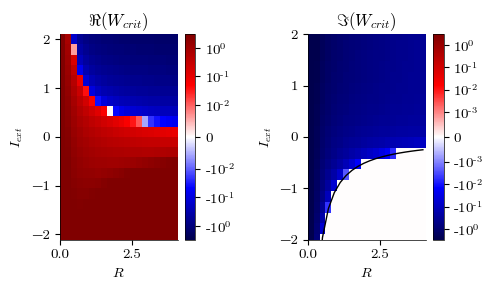

In [219]:
fig, ax = plt.subplots(ncols=2, figsize=(5, 3), dpi=100)

pcm = ax[0].pcolormesh(Rs, Is, z.real, cmap='seismic', norm=mpl.colors.SymLogNorm(0.01, vmin=-3, vmax=3))
fig.colorbar(pcm, ax=ax[0])
ax[0].set_title('$\\Re (W_{crit})$')
ax[0].set_xlabel('$R$')
ax[0].set_ylabel('$I_{ext}$')

pcm = ax[1].pcolormesh(Rs, Is, z.imag, cmap='seismic', norm=mpl.colors.SymLogNorm(0.001, vmin=-3, vmax=3))
fig.colorbar(pcm, ax=ax[1])
ax[1].plot(Rs, -1/Rs, zorder=2)
ax[1].set_ylim((min(Is), max(Is)))  # the condition to have real values
ax[1].set_title('$\\Im (W_{crit})$')
ax[1].set_xlabel('$R$')
ax[1].set_ylabel('$I_{ext}$')

plt.show()

In [261]:
sol_W.evalf(subs={I: -1, R: 1})  # $W_{crit}$ at $R=1$

2.00000000000000

/run/media/niels/niels_data/Documents/2018 EPFL/PH MA 2/BIO-465 Biological modeling of neural networks/project/BIO465-cortical-surround-suppression/src/tufte_mpl/__init__.py:44: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim((m0, m1))


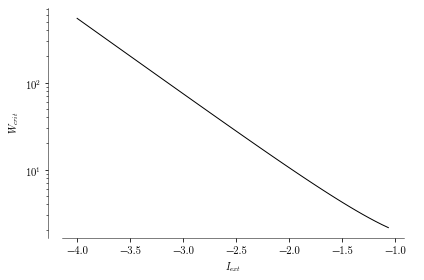

In [225]:
Is = np.linspace(-4, -1/1, 50)
Wcrits = np.zeros_like(Is)
for idx in range(len(Is)):
	Wcrit = complex(sol_W.evalf(subs={I: Is[idx], R: 1}))
	if Wcrit.imag != 0:
		Wcrits[idx] = np.nan
	else:
		Wcrits[idx] = Wcrit.real

fig, ax = plt.subplots()
ax.plot(Is, Wcrits)
ax.set_xlabel('$I_{ext}$')
ax.set_ylabel('$W_{crit}$')
ax.set_yscale('log')
breathe(ax)

plt.show(fig)

### Linear rate network

We replace the sigmoidal activation by the identity function $F(h) = \text{Id}(h) = h$, making the network linear.

Using matrix notation where $\vec h = (h_1, \cdots, h_n)$, $\vec R = (R_1, \cdots, R_n)$, and $\odot$ is the elementwise product, we get

$$
\vec{\tau} \odot \dot{\vec h} = -\vec h + \vec R \odot W \vec h + \vec R \odot \vec{I_{ext}}
$$

If $I_{ext}$ is constant in time, the equation reduces to the form

$$
\vec h = A \vec h + \vec{B} ,\; \text{with}\; \vec{h}(0) = \vec{h_0}
$$

which solves to

$$
\vec{h}(t) = 
\begin{cases}
A^{-1}(\text{exp}(A t)(A \vec{h_0} + \vec{B}) - \vec{B}) \quad \text{if $A$ is non-singular} \\
\vec{B} t \quad \text{if $A = 0$} \\
\text{a sum of exponential and linear term in each component} \quad \text{if $A$ has null and non-null eigenvalues}
\end{cases}
$$

In this case,

$$
A = (1/\vec{\tau}) \odot (\vec R \odot W - \text{Id}) \\
\vec{B} = (1/\vec{\tau}) \odot (\vec R \odot \vec{I_{ext}})
$$

In [12]:
def linear_solution(pop: Populations, y0: np.ndarray):
	alpha = (pop.R * pop.W - np.eye(*pop.W.shape)) / pop.tau[:, None]
	beta = (pop.R * pop.I_ext(0)) / pop.tau
	def h(t: float) -> np.ndarray:
		return np.linalg.inv(alpha) @ (scipy.linalg.expm(alpha * t) @ (alpha @ y0 + beta) - beta)
	def vec_h(t: np.ndarray) -> np.ndarray:
		hs = np.zeros((len(t), pop.W.shape[0]))
		return np.array([h(t_) for t_ in t])
	return vec_h

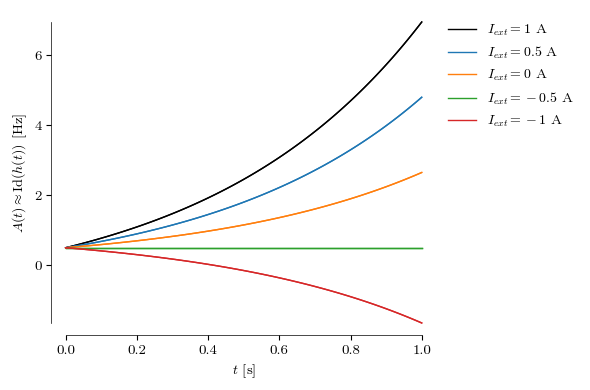

In [25]:
plt.close()
fig, ax = plt.subplots(dpi=100)

for I_ext in reversed((-1, -0.5, 0, 0.5, 1)):
	pop = Populations(W=np.array([[2]]), tau=np.array([0.60]), R=1, gain_fn=identity, I_ext=Flat(np.array([I_ext])))
	res = pop.simulate_h(np.array([0.5]), (0, 1), dt_max=0.01)
	line, = ax.plot(res.t, pop.gain_fn(res.y[0]), label=f'$I_{{ext}} = {I_ext}$ A')
	ax.plot(res.t, linear_solution(pop, np.array([0.5]))(res.t), color=line.get_color())

ax.set_xlabel('$t$ [s]')
ax.set_ylabel('$A(t) \\approx \\mathrm{Id}(h(t))$ [Hz]')
# ax.set_ylim((0, 1))
data_lim(ax, which='both')
breathe(ax)
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

fig.set_size_inches((4, 2))
fig.savefig('../report/figures/pop_single_linear.pdf')

The solution is exponential, meaning it always explodes (for non-zero initial conditions).

So $I_{ext} < 0$ simulates an inhibitory current, but in this case, it is not enough to stabilize

## Inhibitation-stabilized network

### Stability of the network as function of excitatory self-coupling

We want to evaluate the stability of the solution

$$
\vec{y}(t) = A^{-1}(\text{exp}(A t)(A \vec{y_0} + \vec{B}) - \vec{B}).
$$

Rewriting $\vec v = A \vec{y_0} + B$,

$$
A \vec{y}(t) = \text{exp}(A t) \vec v - \vec{B}.
$$

The stability of the solution depends on the projection of $\vec{v}$ on the eigenspace of $A$. Components of $\vec{v}$ projected on an eigenspace associated to an eigenvalue

- $\lambda < 0$ vanish as $t \rightarrow \infty$
- $\lambda > 0$ diverge as $t \rightarrow \infty$
- $\lambda = 0$ are linear ($A$ is singular)

For the solution to be stable, we must therefore impose that all eigenvalues of $A$ are negative.

In [44]:
W00 = sp.Symbol('W_{00}', real=True)  # excit -> excit
W01 = sp.Symbol('W_{01}', real=True)  # inhib -> excit
W10 = sp.Symbol('W_{10}', real=True)  # exit -> inhib
W11 = sp.Symbol('W_{11}', real=True)  # inhib -> inhib
W = sp.Matrix([[W00, W01], [W10, W11]])

R = sp.Integer(1)
tau0, tau1 = sp.symbols('\\tau_0 \\tau_1', real=True)
tau = sp.Matrix([[tau0], [tau1]])
I0, I1 = sp.symbols('I_0 I_1', real=True)
I_ext = sp.Matrix([[I0], [I1]])

A = sp.Matrix((R * W - sp.Identity(2)))
A[0, :] /= tau0
A[1, :] /= tau1
B = sp.Matrix((R * I_ext))
B[0] /= tau0
B[1] /= tau1
h0 = sp.Matrix([[0], [0]])
hf = -A.inv() * B

display(Math(f'A = {sp.latex(A)}'))
display(Math(f'B = {sp.latex(B)}'))
display(Math(f'h_0 = {sp.latex(h0)}'))
display(Math(f'h_f = {sp.latex(hf)}'))

for i, eigval in enumerate(A.eigenvals()):
	print('---')
	display(Math(f'\\lambda_{i} = {sp.latex(eigval)}'))
	display(Math(f'W_{{00}}^\\star = {sp.latex(sp.solve(eigval, W00)[0])}'))

print('---')

subs = {
	W01: -4,
	W10: 4,
	W11: -7,
	tau0: 0.06,
	tau1: 0.012
}

W00_star = sp.solve(eigval, W00)[0]
W00_star_num = W00_star.evalf(subs=subs)
display(Math(f'W_{{00}}^\\star \\approx {sp.latex(W00_star_num)}'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

---


<IPython.core.display.Math object>

<IPython.core.display.Math object>

---


<IPython.core.display.Math object>

<IPython.core.display.Math object>

---


<IPython.core.display.Math object>

In [28]:
print(sp.latex(A))

\left[\begin{array}{cc}\frac{W_{00} - 1}{\tau_{0}} & \frac{W_{01}}{\tau_{0}}\\\frac{W_{10}}{\tau_{1}} & \frac{W_{11} - 1}{\tau_{1}}\end{array}\right]


In [35]:
print(sp.latex(W00_star))

\frac{W_{01} W_{10} + W_{11} - 1}{W_{11} - 1}


In [50]:
print(sp.latex(hf))

\left[\begin{matrix}- \frac{I_{0} \left(W_{11} \tau_{0} - \tau_{0}\right)}{\tau_{0} \left(W_{00} W_{11} - W_{00} - W_{01} W_{10} - W_{11} + 1\right)} + \frac{I_{1} W_{01}}{W_{00} W_{11} - W_{00} - W_{01} W_{10} - W_{11} + 1}\\\frac{I_{0} W_{10}}{W_{00} W_{11} - W_{00} - W_{01} W_{10} - W_{11} + 1} - \frac{I_{1} \left(W_{00} \tau_{1} - \tau_{1}\right)}{\tau_{1} \left(W_{00} W_{11} - W_{00} - W_{01} W_{10} - W_{11} + 1\right)}\end{matrix}\right]


In this case, we can explicitly solve and find the system is stable when $W_{00} < W_{00}^\star = 3.0$. It diverges for $W_{00} > W_{00}^\star$ and evolves linearly when $W_{00} = W_{00}^\star$ (both eigenvalues are null with the same condition).

We denote $\vec{h_f} = A^{-1} \vec{B}$ the value to which $\vec{h}$ converges. It depends on $W$, $\vec{I_{ext}}$, and more surprisingly $\tau$. In the case of one population, there was no "competition" and the system can converge at any speed. In the case of two populations, the competition means that now the rate of convergence matters.

Matrix([[-5.00000000000000], [-1.75000000000000]])
Matrix([[4.57740602766266e+77], [-1.70069631067308e+77]])
Matrix([[5.00000000000000], [3.25000000000000]])


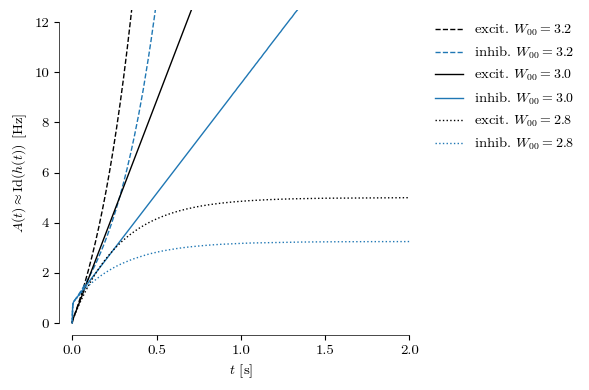

In [46]:
plt.close()
fig, ax = plt.subplots(dpi=100)

for idx, W00_num in enumerate(reversed((2.8, 3.0, 3.2))):
	ax.set_prop_cycle(None)

	pop = Populations(W=np.array([[W00_num, -4], [4, -7]]), tau=np.array([0.06, 0.012]), R=1, gain_fn=identity, I_ext=Flat(np.array([4.0, 6.0])))
	res = pop.simulate_h(np.array([0, 0]), (0, 2))
	
	subs_ = subs | {W00: W00_num, I0: 4.0, I1: 6.0}
	print(hf.evalf(subs=subs_))
	
	linestyle = {0: 'dashed', 1: 'solid', 2: 'dotted'}.get(idx)
	ax.plot(res.t, pop.gain_fn(res.y[0]), label=f'excit. $W_{{00}} = {W00_num}$', linestyle=linestyle)
	ax.plot(res.t, pop.gain_fn(res.y[1]), label=f'inhib. $W_{{00}} = {W00_num}$', linestyle=linestyle)

	# h_sol = linear_solution(pop, np.array([0, 0]))(res.t)
	# ax.plot(res.t, h_sol[:, 0])
	# ax.plot(res.t, h_sol[:, 1])

ax.set_xlabel('$t$ [s]')
ax.set_ylabel('$A(t) \\approx \\mathrm{Id}(h(t))$ [Hz]')
ax.set_ylim((0, 12))
data_lim(ax, which='x')
breathe(ax)
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

fig.set_size_inches((4, 2))
fig.savefig('../report/figures/pop_ei_linear.pdf')

The numerical simulations (setting $W_{10} = 4$, $I_0 = 4.0$, $I_1 = 6.0$) confirm the analytical derivations. In the converging case $W_{00} = 2.8 < W_{00}^\star = 3.0$, the excitatory activity converges to $A = 5 \; \text{Hz}$, and the inhibitory activity converges to $A = 3.25 \; \text{Hz}$

This linear analysis extends to the sigmoidal gain function $F(h) = \text{tanh}(h)$ in the case of a small potential $h$ :

$$
\text{tanh}(h) = h + \mathcal{O}(h^2) \approx \text{Id}(h)
$$

In [41]:
x = sp.Symbol('x')
sp.series((sp.tanh(x) + 1)/2)

1/2 + x/2 - x**3/6 + x**5/15 + O(x**6)

### f-I curve

The computed of $\vec{h_f}$ is of the form, where $\text{cst}$ terms are functions of $W$ and $\tau$

$$
\vec{h_f} = \begin{pmatrix}
	\text{cst} \cdot I_0 + \text{cst} \cdot I_1 \\
	\text{cst} \cdot I_0 + \text{cst} \cdot I_1
\end{pmatrix}
$$

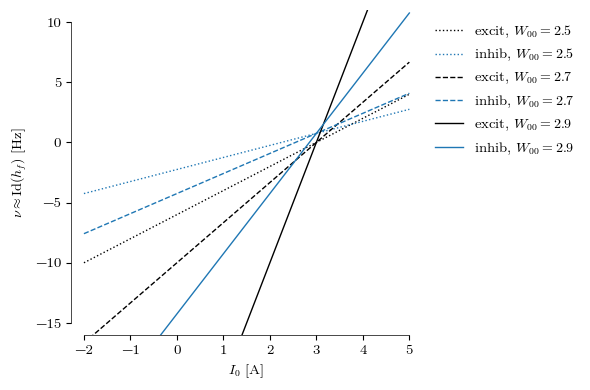

In [49]:
fig, ax = plt.subplots(dpi=100)
I_exts = np.linspace(-2, 5, 100)

for idx, W00_num in enumerate((2.5, 2.7, 2.9)):
	fs = []
	ax.set_prop_cycle(None)  # reset color cycle

	for I_ext in I_exts:
		subs_ = subs | {W00: W00_num, I0: I_ext, I1: 6.0}
		hf_num = hf.evalf(subs=subs_)
		fs.append(np.array(hf_num, dtype=float).squeeze())
		# pop = Populations(W=np.array([[W00_num, -4], [4, -7]]), tau=np.array([0.06, 0.012]), R=1, gain_fn=identity, I_ext=Flat(np.array([I_ext, 6.0])))
		# res = pop.simulate_h(np.array([0, 0]), (0, 2), dt_max=0.1)
		# fs.append(pop.gain_fn(res.y[:, -1]))

	ax.plot(I_exts, fs, linestyle={0: 'dotted', 1: 'dashed', 2: 'solid'}.get(idx), label=[f'excit, $W_{{00}} = {W00_num}$', f'inhib, $W_{{00}} = {W00_num}$'])

ax.set_xlabel('$I_0$ [A]')
ax.set_ylabel('$\\nu \\approx \\mathrm{Id}(h_f)$ [Hz]')
ax.set_ylim((-15, 10))
data_lim(ax, which='x')
breathe(ax)
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

fig.set_size_inches((4, 2))
fig.savefig('../report/figures/pop_ei_linear_fI.pdf')

The f-I curve is linear, as expected from the form of $\vec{h_f}$. Stronger excitatory self-couplings are associated to a steeper curve.

Compared to the linear excitatory-only network which (nearly) always diverges exponentially, the addition of an inhibitory population allows for the existence of stable regimes.

This shows that constant inhibitory current is not enough to stabilize the system, it needs to scale with the activity of the excitatory population, as it does here.

# Modeling surround suppression

## Network mechanisms of surround suppression

Surround stimulus = more nearby neurons are excited -> nearby neighbours add currents -> higher or lower activitiy of the center

For surround suppression, we have a population of neighbour neurons which add a negative current contribution to the center, which is modeled by the inhibitory population.

The central neuron(s) is modeled as the excitatory population.

By increasing the current to the inhibitory population, we are modeling exciting more of the surrounding population.

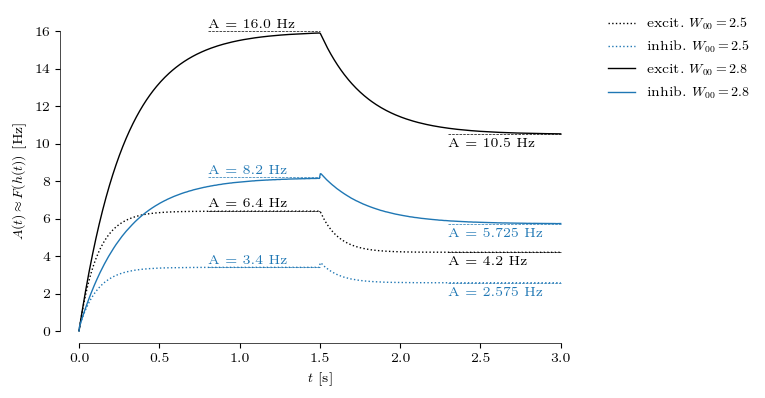

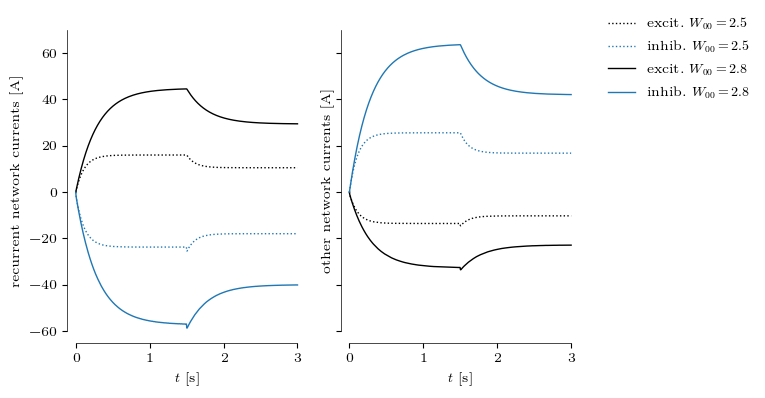

In [117]:
plt.close()

fig_A, ax_A = plt.subplots(dpi=100)
fig_I, ax_I = plt.subplots(dpi=100, ncols=2, sharey=True)

for idx, W00_num in enumerate((2.5, 2.8)):
	pop = Populations(
		W=np.array([[W00_num, -4], [4, -7]]),
		tau=np.array([0.06, 0.012]),
		R=1,
		gain_fn=identity,
		I_ext=(1-Heaviside(1.5))*Flat(np.array([4.0, 1.6])) + Heaviside(1.5)*Flat(np.array([4.0, 3.8]))
	)
	res = pop.simulate_h(np.array([0, 0]), (0, 3), dt_max=0.01)

	subs_ = subs | {W00: pop.W[0, 0], I0: 4.0, I1: 1.6}
	hf_num1 = np.array(hf.evalf(subs=subs_)).squeeze()
	subs_ = subs | {W00: pop.W[0, 0], I0: 4.0, I1: 3.8}
	hf_num2 = np.array(hf.evalf(subs=subs_)).squeeze()
	# print(hf_num1, hf_num2)

	linestyle = {0: 'dotted', 1: 'solid'}.get(idx)

	# plot activations

	ax_A.set_prop_cycle(None)
	ax_A.plot(res.t, pop.gain_fn(res.y[0]), linestyle=linestyle, label=f'excit. $W_{{00}} = {W00_num}$')
	ax_A.plot(res.t, pop.gain_fn(res.y[1]), linestyle=linestyle, label=f'inhib. $W_{{00}} = {W00_num}$')
	ax_A.set_prop_cycle(None)
	line, = ax_A.plot([2.3, 3.0], [hf_num2[0], hf_num2[0]], linestyle='--', linewidth=0.5)
	ax_A.text(2.3, hf_num2[0]-0.2, f'A = {hf_num2[0]:.1f} Hz', va='top', color=line.get_color())
	line, = ax_A.plot([2.3, 3.0], [hf_num2[1], hf_num2[1]], linestyle='--', linewidth=0.5)
	ax_A.text(2.3, hf_num2[1]-0.2, f'A = {hf_num2[1]:.3f} Hz', va='top', color=line.get_color())
	ax_A.set_prop_cycle(None)
	line, = ax_A.plot([0.8, 1.5], [hf_num1[0], hf_num1[0]], linestyle='--', linewidth=0.5)
	ax_A.text(0.8, hf_num1[0]+0.2, f'A = {hf_num1[0]:.1f} Hz', va='baseline', color=line.get_color())
	line, = ax_A.plot([0.8, 1.5], [hf_num1[1], hf_num1[1]], linestyle='--', linewidth=0.5)
	ax_A.text(0.8, hf_num1[1]+0.2, f'A = {hf_num1[1]:.1f} Hz', va='baseline', color=line.get_color())

	# plot currents

	ax_I[0].set_prop_cycle(None)
	ax_I[1].set_prop_cycle(None)
	ax_I[0].plot(res.t, [pop.I_network_recurrent(h) for h in res.y.T], linestyle=linestyle)
	ax_I[1].plot(res.t, [pop.I_network_others(h) for h in res.y.T], linestyle=linestyle, label=[f'excit. $W_{{00}} = {W00_num}$', f'inhib. $W_{{00}} = {W00_num}$'])

ax_A.set_xlabel('$t$ [s]')
ax_A.set_ylabel('$A(t) \\approx F(h(t))$ [Hz]')
ax_A.set_ylim((0, 16))
data_lim(ax_A, which='x')
breathe(ax_A)

fig_A.legend(bbox_to_anchor=(1, 1), loc='upper left')

ax_I[0].set_xlabel('$t$ [s]')
ax_I[1].set_xlabel('$t$ [s]')
ax_I[0].set_ylabel('recurrent network currents [A]')
ax_I[1].set_ylabel('other network currents [A]')

for ax_I_ in ax_I:
	ax_I_.set_ylim((-60, 70))
	data_lim(ax_I_, which='x')
	breathe(ax_I_)

fig_I.legend(bbox_to_anchor=(1, 1), loc='upper left')

plt.show()

<IPython.core.display.Math object>

<IPython.core.display.Math object>

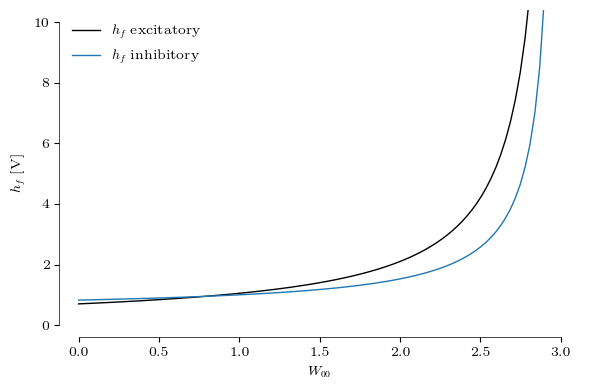

In [191]:
hf_num_fn = hf.subs(subs | {I0: 4.0, I1: 3.8})

display(Math(f'\\text{{excit. }} h_f = {sp.latex(hf_num_fn[0,0].factor(W00).expand())}'))
display(Math(f'\\text{{inhib. }} h_f = {sp.latex(hf_num_fn[1,0].factor(W00).expand())}'))

plt.close()

fig, ax = plt.subplots(dpi=100)
W00s = np.linspace(0, 2.99, 100)
ax.plot(
	W00s, np.array([hf_num_fn.evalf(subs={W00: W00_num}) for W00_num in W00s]).squeeze(),
	label=['$h_f$ excitatory', '$h_f$ inhibitory']
)

ax.set_xlabel('$W_{00}$')
ax.set_ylabel('$h_f$ [V]')
ax.legend()

ax.set_xlim((0, 3))
ax.set_ylim((0, 10))
breathe(ax)

plt.show()

We set $W_{00}$ such that the system is always stable, and converges (exponentially) to the stationary solution independantly of the initial condition, as derived in sec. 1.2.

The recurrent currents scale with the activity of the population. As the activity the excitatory population grows, so does the input current to the inhibitory population, which in term increases the negative current contribution to the excitatory population.

Lowering $W_{00}$ results in convergence to a lower activity level for both populations. This is expected as from the analytical derivation, asymptotically

$$
\vec{h_f} \sim \begin{pmatrix}

	\frac{1}{W_{00} - W_{00}^\star} \\
	\frac{1 - W_{00}}{W_{00} - W_{00}^\star}

\end{pmatrix}
$$

## Orientation tuning of surround suppression

Orientation tuning is a consequence of the difference in neuronal receptive fields. For example, some have a receptive field which matches vertical stripes, thus responding strongly to them. If another, different excitation is applied (i.e. horizontal stripes) which doesn't match the receptive field, then the response isn't as strong.

In the brain, neurons are often arranged such that neurons with similar receptive fields are spatially close.

In our excitatory-inhibitory population model, we can model sensitivity to different stimuli as an increase (or decrease) of the input current to the neuron. Surround suppression for cross-oriented stimuli (of the surround population) is therefore modeled as an lower input current $I_1$ than in for iso-oriented stimuli. This has already been simulated in sec 2.2 : the first half of the simulation has a lower input current (cross-oriented simuli) to the inhibitory population, and the second half has a higher current (iso-oriented simuli), resulting in an activity of the excitatory neuron higher in the first than in the latter.

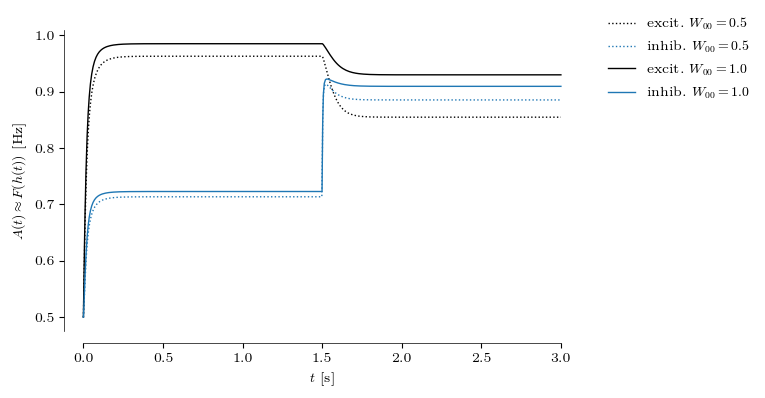

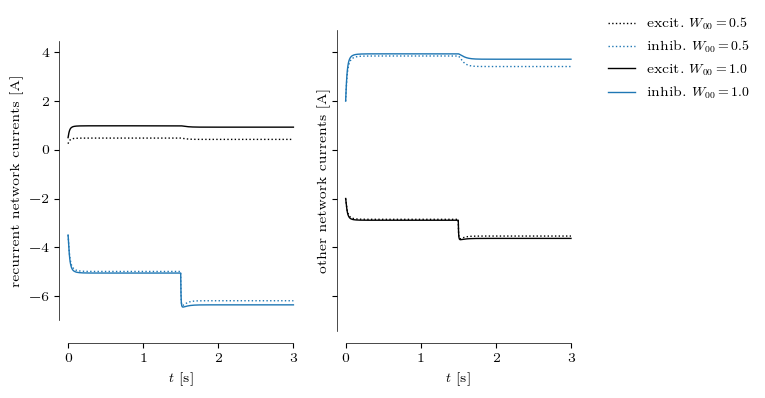

In [196]:
plt.close()

fig_A, ax_A = plt.subplots(dpi=100)
fig_I, ax_I = plt.subplots(dpi=100, ncols=2, sharey=True)

for idx, W00_num in enumerate((0.5, 1.0)):
	pop = Populations(
		W=np.array([[W00_num, -4], [4, -7]]),
		tau=np.array([0.06, 0.012]),
		R=1,
		gain_fn=sigmoid,
		I_ext=(1-Heaviside(1.5))*Flat(np.array([4.0, 1.6])) + Heaviside(1.5)*Flat(np.array([4.0, 3.8]))
	)
	res = pop.simulate_h(np.array([0, 0]), (0, 3), dt_max=0.01)

	linestyle = {0: 'dotted', 1: 'solid'}.get(idx)

	# plot activations

	ax_A.set_prop_cycle(None)
	ax_A.plot(res.t, pop.gain_fn(res.y[0]), linestyle=linestyle, label=f'excit. $W_{{00}} = {W00_num}$')
	ax_A.plot(res.t, pop.gain_fn(res.y[1]), linestyle=linestyle, label=f'inhib. $W_{{00}} = {W00_num}$')

	# plot currents

	ax_I[0].set_prop_cycle(None)
	ax_I[1].set_prop_cycle(None)
	ax_I[0].plot(res.t, [pop.I_network_recurrent(h) for h in res.y.T], linestyle=linestyle)
	ax_I[1].plot(res.t, [pop.I_network_others(h) for h in res.y.T], linestyle=linestyle, label=[f'excit. $W_{{00}} = {W00_num}$', f'inhib. $W_{{00}} = {W00_num}$'])

ax_A.set_xlabel('$t$ [s]')
ax_A.set_ylabel('$A(t) \\approx F(h(t))$ [Hz]')
# ax_A.set_ylim((0, 16))
data_lim(ax_A, which='x')
breathe(ax_A)

fig_A.legend(bbox_to_anchor=(1, 1), loc='upper left')

ax_I[0].set_xlabel('$t$ [s]')
ax_I[1].set_xlabel('$t$ [s]')
ax_I[0].set_ylabel('recurrent network currents [A]')
ax_I[1].set_ylabel('other network currents [A]')

for ax_I_ in ax_I:
	# ax_I_.set_ylim((-60, 70))
	data_lim(ax_I_, which='x')
	breathe(ax_I_)

fig_I.legend(bbox_to_anchor=(1, 1), loc='upper left')

plt.show()

TODO :
- use sigmoid activation this time ?
- "maximal amplitude of the transient increase in inhibitory firing" ??
- "during center and center+surround stimulation for the E and I population" ?? so we don't use linear ?

## Surround suppression in networks with bio-plausible connectivity

The equations for a single neuron are the same as for an entire population. The population equation is based on the mean field approximation, which uses a "mean neuron" to model the entire population, assumed to be mostly homogeneous. Note that more complicated equations (i.e. including ionic currents, channel openings, etc.) exist to model a single neuron. Here, we model neuron $k$ as :

$$\tau_k \dot h_k(t) = -h_k(t) + r_k \sum_n w_{kn} a_n(t) + r_k i_{ext,k}(t)$$

where

$$a_n(t) = \int_0^\infty \alpha_n(s) F_n(h_n(t-s)) \; \text{d}s$$

### Population model renormalization

We denote $[K]$ the ensemble of neurons belonging to the population (multi-)index $K$, and $|K|$ the number of neurons in population $K$

The voltage, activity and external currents of the "mean field" population (indexed by $K$) composed of neurons $k \in [K]$ can be expressed as

$$
H_K(t) = \frac{1}{|K|} \sum_{k \in [K]} h_k(t),\quad A_K(t) = \frac{1}{|K|} \sum_{k \in [K]} a_k(t),\quad I_{ext,K} = \frac{1}{|K|} \sum_{k \in [K]} i_{ext,k}(t)
$$

and modeled by 

$$
\Tau_K \dot H_K(t) = -H_K(t) + R_K \sum_{N} W_{KN} A_N(t) + R_K I_{ext,K}(t).
$$

In the mean-field approximation, we model all neuron $k$ in population $K$ as being the same. Denoting $\mathcal P(k) = K$ as the population multi-index $K$ corresponding to neuron $k$, we substitute to find the equation for the "mean neuron" (all terms in $\sum_{k \in [K]}$ are identical) :

$$
\Tau_{K(k)} \dot h_k(t) = - h_k(t) + R_{K(k)} \sum_N W_{\mathcal P(k),N} \frac{1}{|N|} \sum_{n \in [N]} a_n(t) + R_K i_{ext,k}(t)
$$

Noting $\sum_n = \sum_N \sum_{n \in [N]}$, we simplify

$$
\Tau_{\mathcal P(k)} \dot h_k(t) = - h_k(t) + R_{\mathcal P(k)} \sum_n \frac{1}{|N|} W_{\mathcal P(k),\mathcal P(n)} a_n(t) + R_K i_{ext,k}(t).
$$

Imposing the following constraints completes the renormalization :

$$
\tau_k = \Tau_{\mathcal P(k)}, \quad r_k = R_{\mathcal P(k)}, \quad w_{kn} = \frac{1}{|N|} W_{\mathcal P(k),\mathcal P(n)}
$$

This result matches our intuition, as rescaling should leave the inputs to a neuron/population unchanged.

We verify the renormalization numerically, by simulating the full population $h_k(t)$ and the corresponding renormalized population $H_{\mathcal P(k)}(t)$.

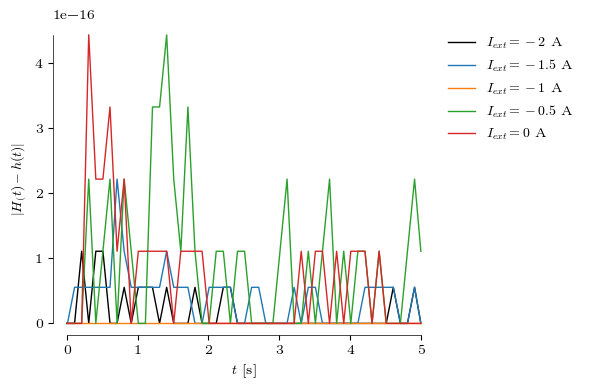

In [67]:
K = 512  # number of neurons in each population

plt.close()
fig, ax = plt.subplots(dpi=100)

for I_ext in (-2, -1.5, -1, -0.5, 0):
	pop_renorm = Populations(
		W=np.array([[2]]),
		tau=np.array([0.6]),
		R=1,
		gain_fn=sigmoid,
		I_ext=Flat(I_ext)
	)

	pop = Populations(
		W=np.full((K, K), pop_renorm.W[0,0]/K),
		tau=np.full(K, pop_renorm.tau[0]),
		R=1,
		gain_fn=sigmoid,
		I_ext=Flat(I_ext)
	)

	res_renorm = pop_renorm.simulate_h(np.array([0]), (0, 5), dt_max=0.1)
	res = pop.simulate_h(np.zeros(K), (0, 5), dt_max=0.1)
	diff = np.abs(pop_renorm.gain_fn(res_renorm.y.T) - pop.gain_fn(res.y).T)

	assert np.allclose(diff, 0)
	ax.plot(res.t, diff[:, 0], label=f'$I_{{ext}} = {I_ext}$ A')

ax.set_ylabel('$|H_(t) - h(t)|$')
ax.set_xlabel('$t$ [s]')
data_lim(ax, 'both')
breathe(ax)
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show(fig)

The difference between the simulations stays within machine precision.

For multiple populations, $w$ becomes a block-matrix :

$$
w = \begin{pmatrix}
	(W_{00})_{K \times K} & (W_{01})_{K \times K} \\
	(W_{10})_{K \times K} & (W_{11})_{K \times K}
\end{pmatrix}
$$

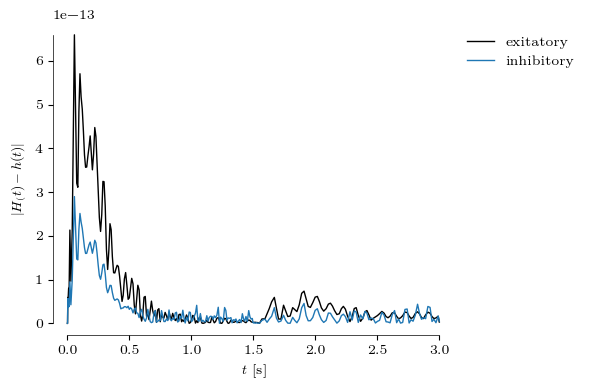

In [92]:
K = 256  # number of neurons in each population

plt.close()
fig, ax = plt.subplots(dpi=100)

pop_renorm = Populations(
	W=np.array([[0.5, -4], [4, -7]]),
	tau=np.array([0.6, 0.012]),
	R=1,
	gain_fn=sigmoid,
	I_ext=(1-Heaviside(1.5))*Flat(np.array([4.0, 1.6])) + Heaviside(1.5)*Flat(np.array([4.0, 3.8]))
)

pop = Populations(
	W=np.block([[np.full((K, K), W_ij/K) for W_ij in W_i] for W_i in pop_renorm.W]),
	tau=np.block([np.full(K, tau_i) for tau_i in pop_renorm.tau]),
	R=1,
	gain_fn=sigmoid,
	I_ext=\
		(1-Heaviside(1.5))*Flat(np.array(np.block([np.full(K, I_i) for I_i in pop_renorm.I_ext(0)]))) \
		+ Heaviside(1.5)*Flat(np.array(np.block([np.full(K, I_i) for I_i in pop_renorm.I_ext(1.6)])))
)

res_renorm = pop_renorm.simulate_h(np.array([0, 0]), (0, 3), dt_max=0.1)
res = pop.simulate_h(np.zeros(2*K), (0, 3), dt_max=0.1)
diff1 = np.abs(pop_renorm.gain_fn(res_renorm.y[0]) - pop.gain_fn(res.y[:K]))
diff2 = np.abs(pop_renorm.gain_fn(res_renorm.y[1]) - pop.gain_fn(res.y[K:]))

assert np.allclose(diff1, 0, atol=1e-12)
assert np.allclose(diff2, 0, atol=1e-12)
ax.plot(res.t, diff1[0], label=f'exitatory')
ax.plot(res.t, diff2[0], label=f'inhibitory')

ax.set_ylabel('$|H_(t) - h(t)|$')
ax.set_xlabel('$t$ [s]')
data_lim(ax, 'both')
breathe(ax)
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show(fig)

Fluctuations are larger in the case of two interacting populations of neurons, but the simulation stays within machine precision.

### Heterogeneous populations

In the case of random connection probabilities, we need to renormalize the _expected_ weights, and get

$$
w_{kn} = \frac{1}{p |K|} W_{\mathcal P(k), \mathcal P(n)}
$$

In [ ]:
mu, var = sp.symbols('\\mu V', real=True)
mu_, var_ = sp.symbols('\\tilde{\\mu} \\tilde{V}', real=True)
for sol in sp.solve((
	mu_ - sp.exp(mu + var/2),
	var_ - (sp.exp(var) - 1)*sp.exp(2*mu + var)
), (mu, var))[0]:
	display(sol)

log(\tilde{\mu}) - log(\tilde{V}/\tilde{\mu}**2 + 1)/2

log(\tilde{V}/\tilde{\mu}**2 + 1)

In [49]:
def hetero_weights(W, K=128, p=0.05, sigma_mult=2.75):
	def block(w):
		# target mean and std
		mu = np.abs(w/(K*p))
		std = sigma_mult*mu

		# input parameters
		mu_normal = np.log(mu) - np.log(std**2/mu**2 + 1)/2
		std_normal = np.sqrt(np.log(std**2/mu**2 + 1))
		# WARNING : lognormal takes (mu, std) of the underlying _normal_ distribution !!
		block = np.random.lognormal(mean=mu_normal, sigma=std_normal, size=(K, K))
		
		# set the sign
		block =np.copysign(block, w)

		# set non-connections to 0
		conn_mask = np.random.random((K, K)) < p
		block[~conn_mask] = 0

		print(f'after zero weights : mean = {np.mean(block.flat):.3e} (target : {w/K:.3e}), std = {np.std(block.flat):.3e}')

		return block
	
	return np.block([[block(W_ij) for W_ij in W_i] for W_i in W])

#### One population case

after zero weights : mean = 3.988e-03 (target : 3.906e-03), std = 5.501e-02
after zero weights : mean = 4.132e-03 (target : 3.906e-03), std = 6.104e-02
after zero weights : mean = 3.787e-03 (target : 3.906e-03), std = 4.452e-02
after zero weights : mean = 3.906e-03 (target : 3.906e-03), std = 4.401e-02
after zero weights : mean = 3.815e-03 (target : 3.906e-03), std = 4.761e-02


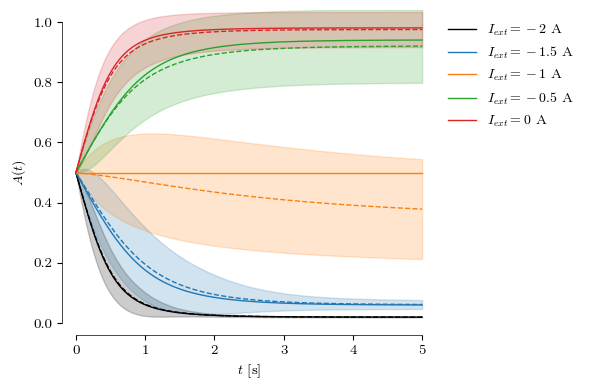

In [74]:
np.random.seed(0)  # reproducible results
K = 512  # number of neurons in a population

plt.close()
fig, ax = plt.subplots(dpi=100)

for I_ext in (-2, -1.5, -1, -0.5, 0):
# for I_ext in (-0.5,):
	pop_renorm = Populations(
		W=np.array([[2]]),
		tau=np.array([0.6]),
		R=1,
		gain_fn=sigmoid,
		I_ext=Flat(I_ext)
	)

	pop = Populations(
		W=hetero_weights(pop_renorm.W, K=K, p=0.05, sigma_mult=2.75),
		# W=hetero_weights(pop_renorm.W, K=K, p=1, sigma_mult=2.75),
		tau=np.full(K, pop_renorm.tau[0]),
		R=1,
		gain_fn=sigmoid,
		I_ext=Flat(I_ext)
	)

	res_renorm = pop_renorm.simulate_h(np.array([0]), (0, 5), dt_max=0.01)
	res = pop.simulate_h(np.zeros(K), (0, 5), dt_max=0.01)

	line, = ax.plot(res_renorm.t, pop_renorm.gain_fn(res_renorm.y[0]), label=f'$I_{{ext}} = {I_ext}$ A')
	# ax.plot(res.t, pop.gain_fn(res.y).T, linewidth=0.05, color=line.get_color(), zorder=-1)
	ax.plot(res.t, pop.gain_fn(np.mean(res.y, axis=0)), color=line.get_color(), linestyle='dashed')
	ax.fill_between(
		res.t, pop.gain_fn(np.mean(res.y, axis=0)) - np.std(pop.gain_fn(res.y), axis=0), pop.gain_fn(np.mean(res.y, axis=0)) + np.std(pop.gain_fn(res.y), axis=0),
		alpha=0.2, color=line.get_color()
	)

ax.set_ylabel('$A(t)$')
ax.set_xlabel('$t$ [s]')
ax.set_ylim((0, 1))
data_lim(ax, 'x')
breathe(ax)
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show(fig)

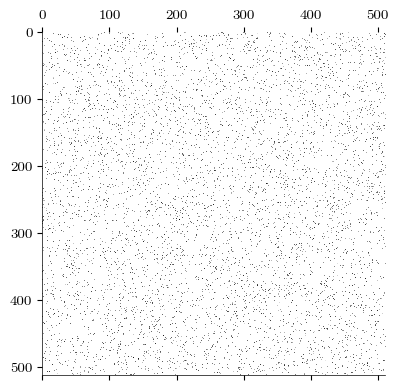

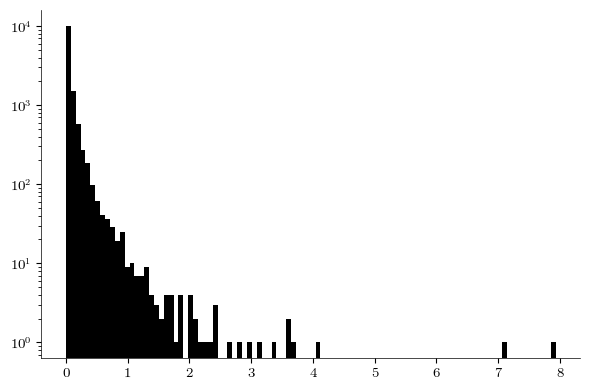

In [75]:
plt.close()
fig, ax = plt.subplots(dpi=100)
ax.matshow(pop.W, cmap='binary', norm=mpl.colors.LogNorm())
plt.show()

plt.close()
fig, ax = plt.subplots(dpi=100)
ax.hist(pop.W[pop.W != 0], bins=100)
ax.set_yscale('log')
plt.show()

#### EI population case

after zero weights : mean = 4.922e-04 (target : 4.883e-04), std = 8.129e-03
after zero weights : mean = -3.882e-03 (target : -3.906e-03), std = 5.049e-02
after zero weights : mean = 3.934e-03 (target : 3.906e-03), std = 4.833e-02
after zero weights : mean = -6.848e-03 (target : -6.836e-03), std = 8.421e-02


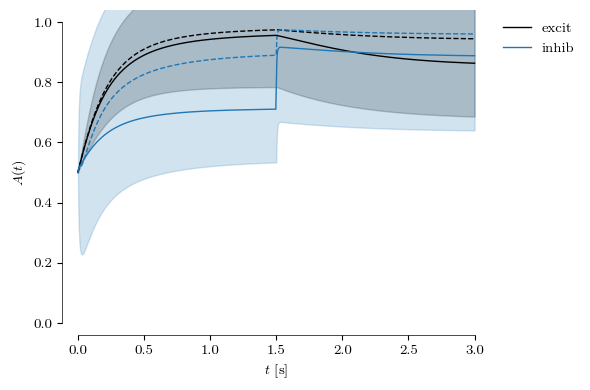

In [95]:
K = 1024  # number of neurons in each population

plt.close()
fig, ax = plt.subplots(dpi=100)

pop_renorm = Populations(
	W=np.array([[0.5, -4], [4, -7]]),
	tau=np.array([0.6, 0.012]),
	R=1,
	gain_fn=sigmoid,
	I_ext=(1-Heaviside(1.5))*Flat(np.array([4.0, 1.6])) + Heaviside(1.5)*Flat(np.array([4.0, 3.8]))
)

pop = Populations(
	W=hetero_weights(pop_renorm.W, K=K, p=0.05, sigma_mult=2.75),
	tau=np.block([np.full(K, tau_i) for tau_i in pop_renorm.tau]),
	R=1,
	gain_fn=sigmoid,
	I_ext=\
		(1-Heaviside(1.5))*Flat(np.array(np.block([np.full(K, I_i) for I_i in pop_renorm.I_ext(0)]))) \
		+ Heaviside(1.5)*Flat(np.array(np.block([np.full(K, I_i) for I_i in pop_renorm.I_ext(1.6)])))
)

res_renorm = pop_renorm.simulate_h(np.array([0, 0]), (0, 3), dt_max=0.1)
res = pop.simulate_h(np.full(2*K, 0), (0, 3), dt_max=0.1)

# ax.plot(res.t, pop.gain_fn(res.y)[K//2-64:K//2].T, linewidth=0.2, color='k')
# ax.plot(res.t, pop.gain_fn(res.y)[K//2:K//2+64].T, linewidth=0.2, color='tab:blue')

ax.plot(res.t, pop.gain_fn(np.mean(res.y[:K//2], axis=0)), color='k', linestyle='dashed')
ax.plot(res.t, pop.gain_fn(np.mean(res.y[K//2:], axis=0)), color='tab:blue', linestyle='dashed')

ax.plot(res_renorm.t, pop_renorm.gain_fn(res_renorm.y[0]), color='k', label='excit')
ax.plot(res_renorm.t, pop_renorm.gain_fn(res_renorm.y[1]), color='tab:blue', label='inhib')

ax.fill_between(
	res.t, pop.gain_fn(np.mean(res.y[:K//2], axis=0)) - np.std(pop.gain_fn(res.y[:K//2]), axis=0), pop.gain_fn(np.mean(res.y[:K//2], axis=0)) + np.std(pop.gain_fn(res.y[:K//2]), axis=0),
	alpha=0.2, color='k'
)
ax.fill_between(
	res.t, pop.gain_fn(np.mean(res.y[K//2:], axis=0)) - np.std(pop.gain_fn(res.y[K//2:]), axis=0), pop.gain_fn(np.mean(res.y[K//2:], axis=0)) + np.std(pop.gain_fn(res.y[K//2:]), axis=0),
	alpha=0.2, color='tab:blue'
)


ax.set_ylabel('$A(t)$')
ax.set_xlabel('$t$ [s]')
ax.set_ylim((0, 1))
data_lim(ax, 'x')
breathe(ax)
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show(fig)

I get the impression that bio-plausible networks have stronger inhibition

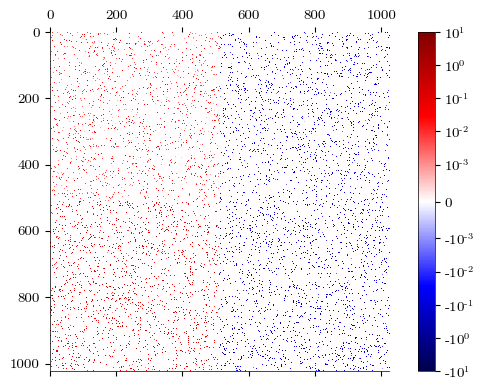

In [69]:
plt.close()
fig, ax = plt.subplots(dpi=100)
im = ax.matshow(pop.W, cmap='seismic', norm=mpl.colors.SymLogNorm(0.001, vmin=-10, vmax=10))
fig.colorbar(im)
plt.show()